In [1]:
# reload magic
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from mldec.datasets import toy_problem_data, toric_code_data
from mldec.models import baselines
from mldec.utils import evaluation

#### Toric code tuning analysis: see which hyperparameters were good
 
 - March 22 only-good-examples
    - lr=0.001 was perfect(!) - every model with this learning rate did perfectly
    - d_model >= 16 will be better
    - dim_feedforward 8,16 not good
TO REMOVE:
    - d_model=4,8, dim_feedforward=8,16,lr=0.0001, 0.005
    - dim_feedforward 8,16 not good

In [4]:
target = "toric-code-v0/transformer_toric_code_only_good_examples_results.csv"

df = pd.read_csv(target)
# df_cnn = pd.read_csv(target_cnn)


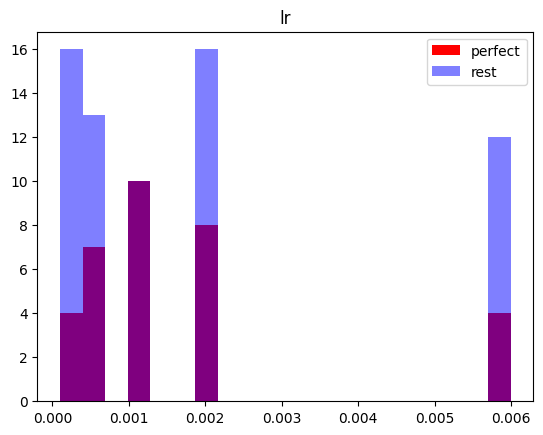

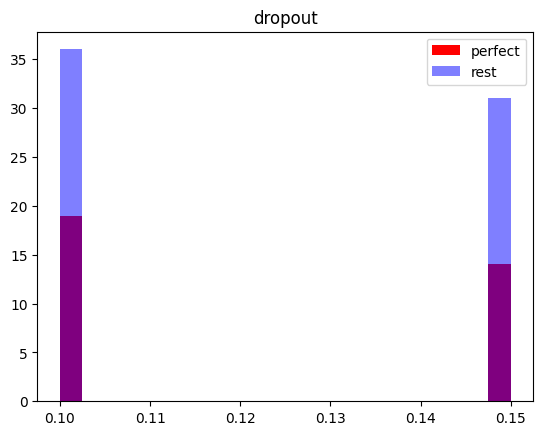

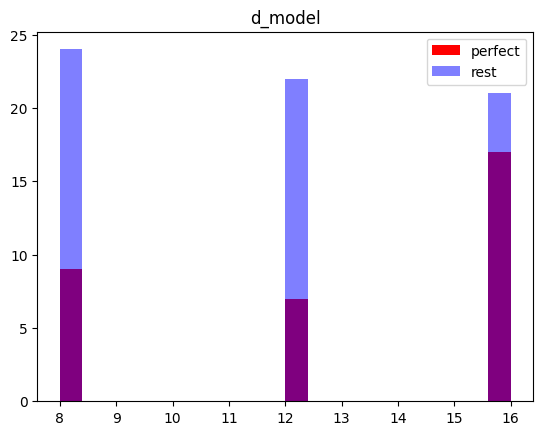

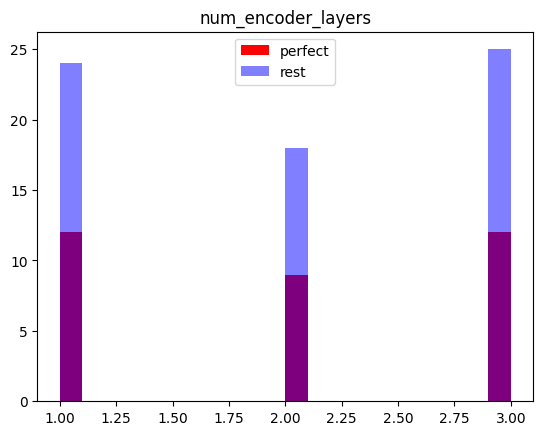

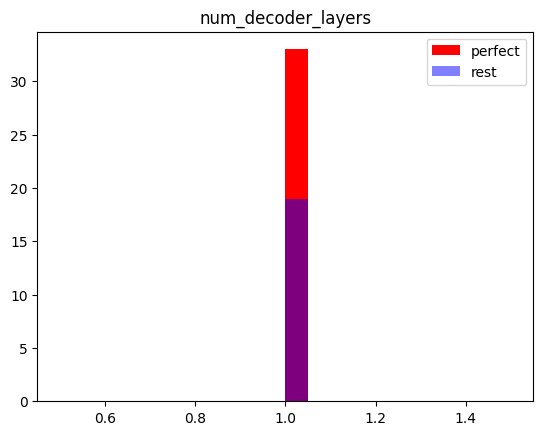

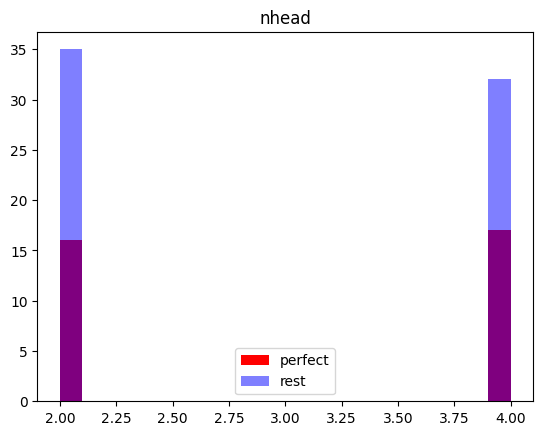

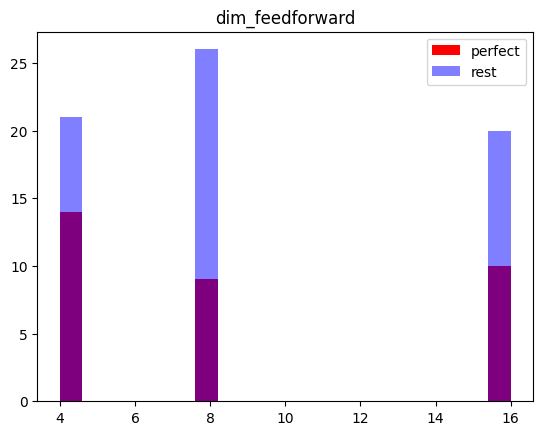

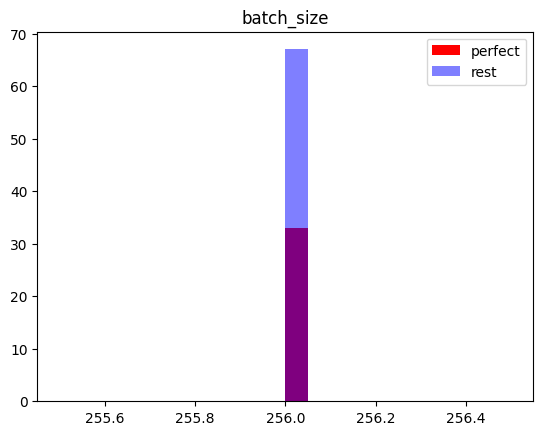

In [4]:
# histogram of 'val_acc' 
# df['val_acc'].hist(bins=20)
def compare_slice_by_column(df, column, slice_by):
    best = df[df[slice_by] == 1]
    other = df[df[slice_by] != 1]
    cts, bins, _ = plt.hist(best[column], bins=20, alpha=1, color='r', label='perfect')
    plt.hist(other[column], bins=bins, alpha=0.5, color='b', label='rest')
    plt.legend()
    plt.title(column)
    plt.show()

for column in ['lr', 'dropout', 'd_model', 'num_encoder_layers', 'num_decoder_layers', 'nhead', 'dim_feedforward', 'batch_size']:
    compare_slice_by_column(df, column, 'val_acc')

## Run analysis

In [5]:
# ORIGINAL 10000 TRAIN
target_var1 = "toric-code-var-exp-v2/transformer_toric_code_results.csv"
target_var2 = "toric-code-var-exp-v2.1/transformer_toric_code_results.csv"
df_var1 = pd.read_csv(target_var1)
df_var2 = pd.read_csv(target_var2)
df_var = pd.concat([df_var1, df_var2] , ignore_index=True)

target_novar1 = "toric-code-novar-exp-v2/transformer_toric_code_results.csv"
target_novar2 = "toric-code-novar-exp-v2.1/transformer_toric_code_results.csv"
df_novar1 = pd.read_csv(target_novar1)
df_novar2 = pd.read_csv(target_novar2)
df_novar = pd.concat([df_novar1, df_novar2], ignore_index=True)

# INFINITE DATA APRIL 4 EXPERIMENT
# target_var1 = "toric-code-var-exp-v3-infinitedata/transformer_toric_code_results.csv"
# df_var = pd.read_csv(target_var1)

# target_novar1 = "toric-code-novar-exp-v3-infinitedata/transformer_toric_code_results.csv"
# df_novar = pd.read_csv(target_novar1)


In [6]:
# there are really big fluctuations at higher betas and its not worth burning the comput to even them out
# so I am discarding the data that jumps around. If you don't like that, you can comment this block out
lb = 0.75
ub = 4.0
step = 0.25
ninc = int((ub - lb) / step) + 1
betavals = np.linspace(lb, ub, ninc)
# remove 3 and 3.5, 4 from betavals: There is nothing inconsistent in these additional results
# but they look like garbage because of statistical fluctuations. Showing thin doesn't add any conclusive
# info, and does not contradict what I amd discussing here already
bad_beta = [3, 3.5, 4, 4.25, 4.5]
# drop all df rows with beta in bad_beta
df_novar = df_novar[~df_novar['beta'].isin(bad_beta)]
df_var = df_var[~df_var['beta'].isin(bad_beta)]
# betavals = np.array([b for b in betavals if b not in bad_beta])

#### Baseline: Weighted MWPM


In [7]:
ptrue = 0.05
var = 0.03
n = 9
dataset_config = {"p": ptrue, "var": var, "beta": 1.0}
X, Y, good_weights = toric_code_data.uniform_over_good_examples(n, dataset_config)
X, Y, val_weights = toric_code_data.create_dataset_training(n, dataset_config)

C:\Users\peter\Desktop\projects\mldec\src\mldec\datasets\toric_code_data.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, Y, probs = torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32), torch.tensor(probs, dtype=torch.float32)


In [8]:
error_probs = toric_code_data.make_variance_noise_model(n, dataset_config, return_probs=True)
print("device qubit errors")
print(error_probs)
# for beta in np.linspace(0.75, 3, 10):
for beta in [1]:
    adjusted_probs = error_probs * beta
    adjusted_probs = np.ones(n) * ptrue * beta
    minimum_weight_decoder = baselines.MinimumWeightPerfectMatching()
    minimum_weight_decoder.make_decoder(None, None, error_probs=error_probs)
    minimum_weight_val_acc = evaluation.weighted_accuracy(minimum_weight_decoder, X, Y, val_weights)
    print("minweight acc: {}".format(minimum_weight_val_acc))


device qubit errors
[0.10890275 0.05827309 0.06375975 0.08003794 0.02708494 0.07165783
 0.02283591 0.0800562  0.03437773]
minweight acc: 0.9524514675140381


### MLD 'trained' on both the true distribution and the no-var distribution

In [9]:
# compute optimal performance on this dataset .9524514

mld = baselines.LookupTable()
mld.train_on_histogram(X, Y, good_weights)
mld_acc = evaluation.weighted_accuracy(mld, X, Y, val_weights) 
print(f"MLD table accuracy: {mld_acc}")

# compute the MLD for a no-variance depolarizing noise model
mld_for_novar = []
mld_for_var = []
betavals = sorted(df_novar['beta'].unique())
for beta in betavals:
    novar_dataset_config = {"p": ptrue, "var": 0, "beta": beta}
    var_dataset_config = {"p": ptrue, "var": var, "beta": beta}
    X, Y, good_novar = toric_code_data.uniform_over_good_examples(n, novar_dataset_config)
    X, Y, good_var = toric_code_data.uniform_over_good_examples(n, var_dataset_config)
    # train an MLD on the no-variance noise model, and then
    # evaluate on the "true" noise profile
    mld_novar = baselines.LookupTable()
    mld_novar.train_on_histogram(X, Y, good_novar)
    acc_novar = evaluation.weighted_accuracy(mld_novar, X, Y, val_weights)
    mld_for_novar.append(acc_novar)

    mld_var = baselines.LookupTable()
    mld_var.train_on_histogram(X, Y, good_var)
    acc_var = evaluation.weighted_accuracy(mld_var, X, Y, val_weights)
    mld_for_var.append(acc_var)
print(mld_for_novar)
print(mld_for_var)



C:\Users\peter\Desktop\projects\mldec\src\mldec\models\baselines.py:62: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\torch\csrc\utils\tensor_new.cpp:257.)
  return torch.tensor(out)


MLD table accuracy: 0.9636911153793335
[0.9606460928916931, 0.9606460928916931, 0.9606460928916931, 0.9606460928916931, 0.9606460928916931, 0.9606460928916931, 0.9606460928916931, 0.9606460928916931, 0.9606460928916931, 0.9606460928916931, 0.9606460928916931]
[0.9636911153793335, 0.9636911153793335, 0.9636911153793335, 0.963622510433197, 0.963622510433197, 0.963622510433197, 0.963622510433197, 0.963622510433197, 0.963577926158905, 0.9512660503387451, 0.9501630663871765]


In [15]:
#  DATA SWEEEP APRIL 11.A EXPERIMENT
# beta =[1, 1.75], var
target_var1 = "toric-code-var-exp-v3.1-datasweep/transformer_toric_code_results.csv"
df_var_sweep = pd.read_csv(target_var1)

# beta=[1, 1.75], novar
target_novar1 = "toric-code-novar-exp-v3.1-datasweep/transformer_toric_code_results.csv"
df_novarx = pd.read_csv(target_novar1)

# beta=3.25, novar
target_novar2 = "toric-code-novar-exp-v3.2-datasweep/transformer_toric_code_results.csv"
df_novar2x = pd.read_csv(target_novar2)
# combine df_novar2 into df_novar
df_novar_sweep = pd.concat([df_novarx, df_novar2x], ignore_index=True)

In [18]:
def ana_by_batch_size(df, col_name, quantile, append_inf=True):
    """For each value of batch_size, compute median and upper/lower quantile of df[col_name]."""
    batch_sizes = df['batch_size'].unique()
    # move 1994 to the end
    batch_sizes = np.array(list(sorted([x for x in batch_sizes if x != 1994])))
    if append_inf:
        batch_sizes = np.concatenate([batch_sizes, [1994]])
    medians = []
    lower_q = []
    upper_q = []
    for bs in batch_sizes:
        vals = 1 - df[df['batch_size'] == bs][col_name]
        medians.append(np.median(vals))
        lower_q.append(np.quantile(vals, 1-quantile))
        upper_q.append(np.quantile(vals, quantile))
    medians = np.array(medians)
    lower_q = medians - np.array(lower_q)
    upper_q = np.array(upper_q) - medians
    bounds = np.array(list(zip(lower_q, upper_q))).T
    return batch_sizes, medians, bounds

def ana_single_batch_size(df, col_name, quantile, batch_size):
    # add a single batch_size column to df
    df["batch_size"] = batch_size
    return ana_by_batch_size(df, col_name, quantile, append_inf=False)

quantile = 0.9
batch_sizes, medians_beta1, bounds_beta1 = ana_by_batch_size(df_var_sweep[df_var_sweep["beta"] == 1], "val_acc", quantile)
batch_sizes, medians_beta175, bounds_beta175 = ana_by_batch_size(df_var_sweep[df_var_sweep["beta"] == 1.75], "val_acc", quantile)
batch_sizes, medians_beta1_novar, bounds_beta1_novar = ana_by_batch_size(df_novar_sweep[df_novar_sweep["beta"] == 1], "val_acc", quantile)
batch_sizes, medians_beta175_novar, bounds_beta175_novar = ana_by_batch_size(df_novar_sweep[df_novar_sweep["beta"] == 1.75], "val_acc", quantile)
batch_sizes, medians_beta325_novar, bounds_beta325_novar = ana_by_batch_size(df_novar_sweep[df_novar_sweep["beta"] == 3.25], "val_acc", quantile)

_, medians_beta1_original, bounds_beta1_original = ana_single_batch_size(df_var[df_var["beta"] == 1], "val_acc", quantile, 10000)
_, medians_beta175_original, bounds_beta175_original = ana_single_batch_size(df_var[df_var["beta"] == 1.75], "val_acc", quantile, 10000)
_, medians_beta1_novar_original, bounds_beta1_novar_original = ana_single_batch_size(df_novar[df_novar["beta"] == 1], "val_acc", quantile, 10000)
_, medians_beta175_novar_original, bounds_beta175_novar_original = ana_single_batch_size(df_novar[df_novar["beta"] == 1.75], "val_acc", quantile, 10000)
_, medians_beta325_novar_original, bounds_beta325_novar_original = ana_single_batch_size(df_novar[df_novar["beta"] == 3.25], "val_acc", quantile, 10000)

C:\Users\peter\AppData\Local\Temp\ipykernel_3264\3105668356.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["batch_size"] = batch_size


In [10]:
# _, _, p_TL_true = toric_code_data.create_dataset_training(n, dataset_config, cache=True)
# p_TL_true = p_TL_true.reshape(-1, 2**2).numpy()
# true_argmaxes = p_TL_true.argmax(1)
# for beta in [3.0]:
#     novar_dataset_config = {"p": ptrue, "var": 0, "beta": beta}
#     X, Y, p_TL = toric_code_data.create_dataset_training(n, novar_dataset_config, cache=True)
#     p_TL = p_TL.reshape(-1, 2**2).numpy()
#     fake_argmaxes = p_TL.argmax(1)

# # print out where the argmaxes differ
# diffs = np.where(true_argmaxes != fake_argmaxes)

# for i in diffs[0]:
#     print(p_TL_true[i], true_argmaxes[i], p_TL[i], fake_argmaxes[i])


unweighted beta=1: 0.037663936614990234, 0.038928270339965765, (0.03823413252830504, 0.039906227588653566)
weighted best: 0.03690415620803844, 0.03736338019371038, (0.03713281154632568, 0.0376413881778717)
unweighted best: 0.03820151090621959, 0.040641963481903076, (0.03979668617248544, 0.04159330129623402)


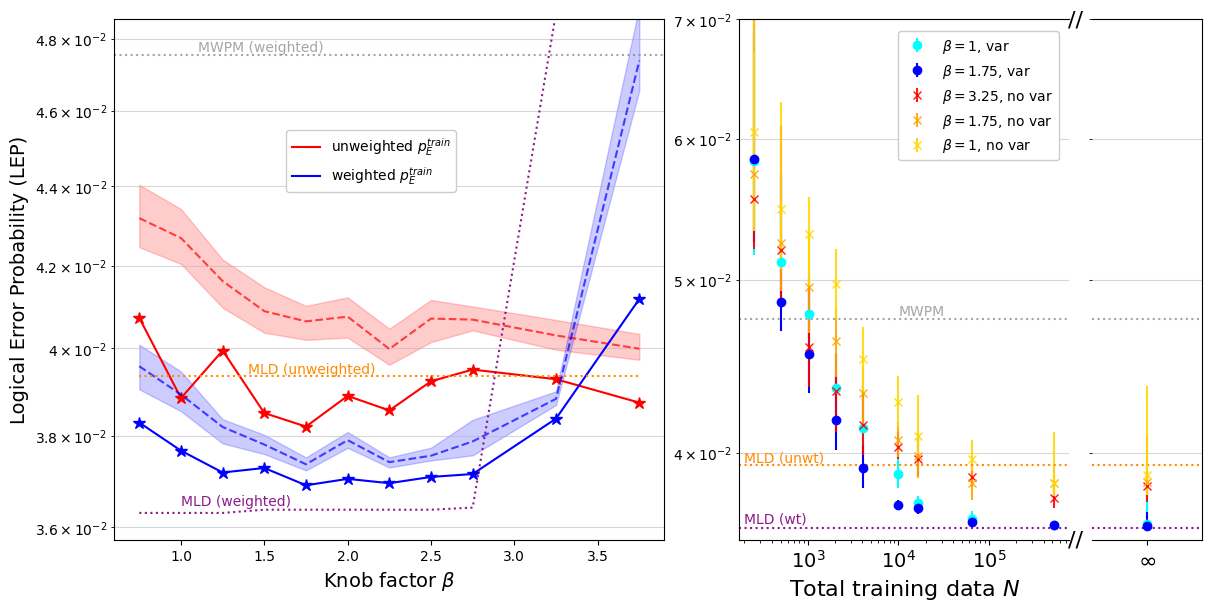

In [86]:
from matplotlib import gridspec


fig = plt.figure(figsize=(12, 6), constrained_layout=True)
gs = gridspec.GridSpec(1, 9, figure=fig)
# Its very frustrating that sharey here forces ylabels to appear.
ax = plt.subplot(gs[0, :5])
ax2 = plt.subplot(gs[0, 5:8])
ax3 = plt.subplot(gs[0, 8])

unwt_xformer_color = 'r'
wt_xformer_color = 'b'
wt_mwpm_color = 'grey'
wt_mld_color = 'purple'
unwt_mld_color = 'darkorange'


colors = [unwt_xformer_color, wt_xformer_color]
labels = [ r'unweighted $p_E^{train}$', r'weighted $p_E^{train}$']
betavals = sorted(df_var['beta'].unique())

for jj, df in enumerate([df_novar, df_var]):
    
    color = colors[jj]
    # compute performance/stats on each of the models
    yerrs_meds = []
    yerrs_mins = []
    yerrs_ub = []
    yerrs_lb = []
    better_than_lookup_arr = [] # track when the model is better than the lookup table
    for i, beta in enumerate(betavals):
        y = df[df['beta'] == beta]['val_acc']
        y_err = 1 - y
        yerrs_meds.append(y_err.median())
        # get 
        y_ub = y_err.quantile(.75)
        y_lb = y_err.quantile(0.25)
        # y_ub = y_err.quantile(.95)
        # y_lb = y_err.quantile(0.05)
        # y_ub = max(y_err)
        # y_lb = min(y_err)
        yerrs_ub.append(y_ub)
        yerrs_lb.append(y_lb)
        yerrs_mins.append(y_err.min())

        # Also get the min weight performance
        # vs_minweight = df[df['beta'] == beta]['vs_minweight'].values
        # minweight = y - vs_minweight
        # min_minweight_err = min(np.round(1 - minweight, 7)) # machine precision errors from the subtraction op above...

        # now, find the comparison of this plot to the lookup table on the plot
        vs_lookup = df[df['beta'] == beta]['vs_lookup'][y.idxmax()]
        better_than_lookup = vs_lookup > 0
        better_than_lookup_arr.append(better_than_lookup)
    
    yerrs_meds = np.array(yerrs_meds)
    yerrs_mins = np.array(yerrs_mins)
    yerrs_ub = np.array(yerrs_ub)
    yerrs_lb = np.array(yerrs_lb)

    # xvals = ptrue * np.array(betavals)
    xvals = np.array(betavals)

    ax.fill_between(xvals, yerrs_lb, yerrs_ub, color=color, alpha=0.2)
    ax.plot(xvals, yerrs_meds, ls='--', marker=None, c=color, alpha=0.7)
    ax.plot(xvals, yerrs_mins, ls='-', marker=None, c=color, label=labels[jj])
    # wherever the result is better than lookup, plot a star
    for i, beta in enumerate(betavals):
        if better_than_lookup_arr[i]:
            marker = '*'
            markersize = 9
        else:
            marker = 'o'
            markersize = 6
        ax.plot(xvals[i], yerrs_mins[i], marker=marker, c=color, markersize=markersize)

    if jj ==1:
        ax.axhline(1 - minimum_weight_val_acc, ls=':', c=wt_mwpm_color, alpha=0.7)
        ax.text(1.1, 1 - minimum_weight_val_acc, "MWPM (weighted)", color=wt_mwpm_color, va='bottom', ha='left', fontsize=10, alpha=0.7)

        ax.plot(xvals, 1 - np.array(mld_for_var), ls=':', c=wt_mld_color, alpha=0.9)
        ax.text(1, 1 - mld_for_var[0] + 0.0001, r"MLD (weighted)", color=wt_mld_color, va='bottom', ha='left', fontsize=10, alpha=0.9)

        ax.plot(xvals, (1 - np.array(mld_for_novar))[:len(xvals)], ls=':', c=unwt_mld_color, alpha=1)
        ax.text(1.4, 1 - mld_for_novar[0], r"MLD (unweighted)", color=unwt_mld_color, va='bottom', ha='left', fontsize=10, alpha=1)

    ax.semilogy()
    ax.set_xlabel(r"Knob factor $\beta$", size=14)

ax.set_ylim([ax.get_ylim()[0], 1 - minimum_weight_val_acc + 1e-3])
# ax.set_ylim([3e-2, 6e-2])
ax.set_ylabel("Logical Error Probability (LEP)", size=14)
# place the legend at (0.7, 0.9) using axis coordinates
ax.legend(loc="upper left", fontsize=10, framealpha=1, bbox_to_anchor=(0.3, 0.8))

# bar plots of the best performance from each category
def best_median_iq_beta(df, beta):
    if beta:
        df = df[df['beta'] == beta]
    else:
        # slice the df to keep only the beta corresponding to maximum val acc
        beta = df.loc[df['val_acc'].idxmax()]['beta']
        df = df[df['beta'] == beta]
    y = df['val_acc']
    errs = 1 - y
    best = errs.min()
    median = errs.median()
    iq = (errs.quantile(0.1), errs.quantile(0.90))
    return best, median, iq


wt_beta1_best, wt_beta1_median, wt_beta1_iq = best_median_iq_beta(df_var, beta=1)
wt_best, wt_median, wt_iq = best_median_iq_beta(df_var, beta=None)
unwt_best, unwt_median, unwt_iq = best_median_iq_beta(df_novar, beta=None)
print(f"unweighted beta=1: {wt_beta1_best}, {wt_beta1_median}, {wt_beta1_iq}")
print(f"weighted best: {wt_best}, {wt_median}, {wt_iq}")
print(f"unweighted best: {unwt_best}, {unwt_median}, {unwt_iq}")
mld_err = 1 - mld_acc
mwpm_err = 1 - minimum_weight_val_acc
mld_unwt_err = 1 - max(mld_for_novar) # this doesn't matter, they're all the same
ax.grid(which='both', alpha=0.5, axis='y')

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 
# second plot is for n_train sweep
# define three shades of red: (pink, red, dark red)
red_rgb = "gold"
red_rgb2 = "orange"
red_rgb3 = "red"

novar_marker="x"
novar_alpha = 0.9

n_batches = 32 # the total training data is this time n_batches
ax2.errorbar(batch_sizes[:-1] * n_batches, medians_beta1[:-1], yerr=bounds_beta1[:,:-1], fmt='o', c='cyan')
ax2.errorbar(batch_sizes[:-1] * n_batches, medians_beta175[:-1], yerr=bounds_beta175[:,:-1], fmt='o', c='b')
ax2.errorbar(batch_sizes[:-1] * n_batches, medians_beta325_novar[:-1], yerr=bounds_beta325_novar[:,:-1], fmt=novar_marker, c=red_rgb3, alpha=novar_alpha)
ax2.errorbar(batch_sizes[:-1] * n_batches, medians_beta175_novar[:-1], yerr=bounds_beta175_novar[:,:-1], fmt=novar_marker, c=red_rgb2, alpha=novar_alpha)
ax2.errorbar(batch_sizes[:-1] * n_batches, medians_beta1_novar[:-1], yerr=bounds_beta1_novar[:,:-1], fmt=novar_marker, c=red_rgb, alpha=novar_alpha)

ax2.annotate('//', xy=(1.02, 0),  xycoords='axes fraction', ha='center', va='center', fontsize=16)
ax2.annotate('//', xy=(1.02, 1),  xycoords='axes fraction', ha='center', va='center', fontsize=16)

# also plot original data
ax2.errorbar(10000, medians_beta1_original[-1], yerr=bounds_beta1_original[:,-1].reshape(2,1), fmt='o', c='cyan', label=r'$\beta=1$, var')
ax2.errorbar(10000, medians_beta175_original[-1], yerr=bounds_beta175_original[:,-1].reshape(2,1), fmt='o', c='b', label=r'$\beta=1.75$, var')
ax2.errorbar(10000, medians_beta325_novar_original[-1], yerr=bounds_beta325_novar_original[:,-1].reshape(2,1), fmt=novar_marker, c=red_rgb3, label=r'$\beta=3.25$, no var', alpha=novar_alpha)
ax2.errorbar(10000, medians_beta175_novar_original[-1], yerr=bounds_beta175_novar_original[:,-1].reshape(2,1), fmt=novar_marker, c=red_rgb2, label=r'$\beta=1.75$, no var', alpha=novar_alpha)
ax2.errorbar(10000, medians_beta1_novar_original[-1], yerr=bounds_beta1_novar_original[:,-1].reshape(2,1), fmt=novar_marker, c=red_rgb, label=r'$\beta=1$, no var', alpha=novar_alpha)

ax2.loglog()
ax2.spines[['right']].set_visible(False)
ax2.set_xlabel(r"Total training data $N$", fontsize=16)

# ax2.set_ylabel(r"Median logical error rate")
# change xticklabel sizes
ax2.tick_params(axis='x', labelsize=14)
# put annotated '//' at y=0, x=xlim[1] in axis coordinates
ax2.grid(which='both', alpha=0.5, axis='y')

plt.setp(ax2.get_yticklabels(), visible=False)
ax2.tick_params(left=False, labelleft=False)
# ax2.set_yticklabels([])
# print(ax.get_yticks())
# ax2.set_yticks(ax.get_yticks())
ax2.set_ylim(ax.get_ylim()[0], 7e-2)
ax2.legend(loc="upper right", fontsize=10, framealpha=1, bbox_to_anchor=(.99, 0.99))

ax2.axhline(1 - minimum_weight_val_acc, ls=':', c=wt_mwpm_color, alpha=0.7)
ax3.axhline(1 - minimum_weight_val_acc, ls=':', c=wt_mwpm_color, alpha=0.7)
ax2.text(1e4, 1 - minimum_weight_val_acc, "MWPM", color=wt_mwpm_color, va='bottom', ha='left', fontsize=10, alpha=0.7)
ax2.axhline(1 - mld_for_var[0], ls=':', c=wt_mld_color, alpha=0.9)
ax3.axhline(1 - mld_for_var[0], ls=':', c=wt_mld_color, alpha=0.9)
ax2.text(200, 1 - mld_for_var[0] + 0.0001, r"MLD (wt)", color=wt_mld_color, va='bottom', ha='left', fontsize=10, alpha=0.9)
ax2.axhline((1 - mld_for_novar[0]), ls=':', c=unwt_mld_color, alpha=1)
ax3.axhline((1 - mld_for_novar[0]), ls=':', c=unwt_mld_color, alpha=1)
ax2.text(200, 1 - mld_for_novar[0], r"MLD (unwt)", color=unwt_mld_color, va='bottom', ha='left', fontsize=10, alpha=1)


ax3.semilogy()
ax3.errorbar(1, medians_beta1[-1], yerr=bounds_beta1[:,-1].reshape(2,1), fmt='o', c='cyan', label=r'$\beta=1$, var')
ax3.errorbar(1, medians_beta175[-1], yerr=bounds_beta175[:,-1].reshape(2,1), fmt='o', c='b', label=r'$\beta=1.75$, var')
ax3.errorbar(1, medians_beta325_novar[-1], yerr=bounds_beta325_novar[:,-1].reshape(2,1), fmt=novar_marker, c=red_rgb3, label=r'$\beta=3.25$, no var', alpha=novar_alpha)
ax3.errorbar(1, medians_beta175_novar[-1], yerr=bounds_beta175_novar[:,-1].reshape(2,1), fmt=novar_marker, c=red_rgb2, label=r'$\beta=1.75$, no var', alpha=novar_alpha)
ax3.errorbar(1, medians_beta1_novar[-1], yerr=bounds_beta1_novar[:,-1].reshape(2,1), fmt=novar_marker, c=red_rgb, label=r'$\beta=1$, no var', alpha=novar_alpha)
ax3.spines[['left']].set_visible(False)


# suppress y-axis on ax3 and ticks
plt.setp(ax3.get_yticklabels(), visible=False)
plt.setp(ax3.get_yminorticklabels(), visible=False)  # <--- THIS IS IT! FOUND IT.
# ax3.tick_params(left=False, labelleft=False)
ax3.set_yticklabels([])
ax3.set_yticks([])
ax3.set_xticks([1])
ax3.set_xticklabels([r"$\infty$"], fontsize=16)
ax3.set_ylim(ax2.get_ylim())
ax3.grid(which='both', alpha=0.5, axis='y')

fig.savefig(f"../../figures/agg_toric_code.pdf", bbox_inches='tight')

In [73]:
ax3.get_yticklabels()

[]

In [82]:
for method in dir(ax3):
    if "get_" in method and "_get" not in method:
        try:
            s = getattr(ax3, method)()
            print(method, ":", s)
        except:
            continue
 

get_adjustable : box
get_agg_filter : None
get_alpha : None
get_anchor : C
get_animated : False
get_aspect : auto
get_autoscale_on : False
get_autoscalex_on : True
get_autoscaley_on : False
get_axes_locator : None
get_axisbelow : line
get_box_aspect : None
get_children : [<matplotlib.lines.Line2D object at 0x000001D43717AA50>, <matplotlib.lines.Line2D object at 0x000001D436B87110>, <matplotlib.lines.Line2D object at 0x000001D437134490>, <matplotlib.lines.Line2D object at 0x000001D437050C50>, <matplotlib.collections.LineCollection object at 0x000001D436CAC310>, <matplotlib.lines.Line2D object at 0x000001D436B858D0>, <matplotlib.collections.LineCollection object at 0x000001D4366DB0D0>, <matplotlib.lines.Line2D object at 0x000001D4370EBAD0>, <matplotlib.collections.LineCollection object at 0x000001D437098990>, <matplotlib.lines.Line2D object at 0x000001D4362BF310>, <matplotlib.collections.LineCollection object at 0x000001D4367B6BD0>, <matplotlib.lines.Line2D object at 0x000001D43708D1D0>,

C:\Users\peter\AppData\Local\Temp\ipykernel_3264\1887452125.py:4: MatplotlibDeprecationWarning: The get_renderer_cache function was deprecated in Matplotlib 3.6 and will be removed two minor releases later. Use Axes.figure.canvas.get_renderer() instead.
  s = getattr(ax3, method)()


In [ ]:
# uninteresting barplot source code
# bars = ax2.bar([0, 1, 2, 3, 4], 
#         [mwpm_err, unwt_best, wt_beta1_best, wt_best, mld_err], 
#         color=[wt_mwpm_color, unwt_xformer_color, 'black', wt_xformer_color, wt_mld_color], alpha=0.7)
# ax2.set_xticks([0, 1, 2, 3, 4])
# alpha_values = [.7, 1, 1, 1, 0.7]
# # also do a yerr plot of median and IQC for beta1, unwt, and wt
# ax2.errorbar([2], [wt_beta1_median], 
#              yerr=[[wt_beta1_median - wt_beta1_iq[0]],
#                    [wt_beta1_iq[1] - wt_beta1_median]],
#              fmt='o', c='k', capsize=5, capthick=2, alpha=1)
# ax2.set_xticklabels([
#     "MWPM",  r"$\beta=1.75$"+"\n(unweighted)", r"$\beta=1$", r"$\beta=1.75$"+"\n(weighted)", r"MLD"
# ], rotation=0, ha='center')

# for bar, alpha in zip(bars, alpha_values):
#     bar.set_alpha(alpha)

# ax2.semilogy()
# ax2.grid(which='both', alpha=0.5)
# ax2.set_axisbelow(True)

### Overflow pictures

#### Accuracy distributions of transformers lookup table

(-0.005, 0.012)

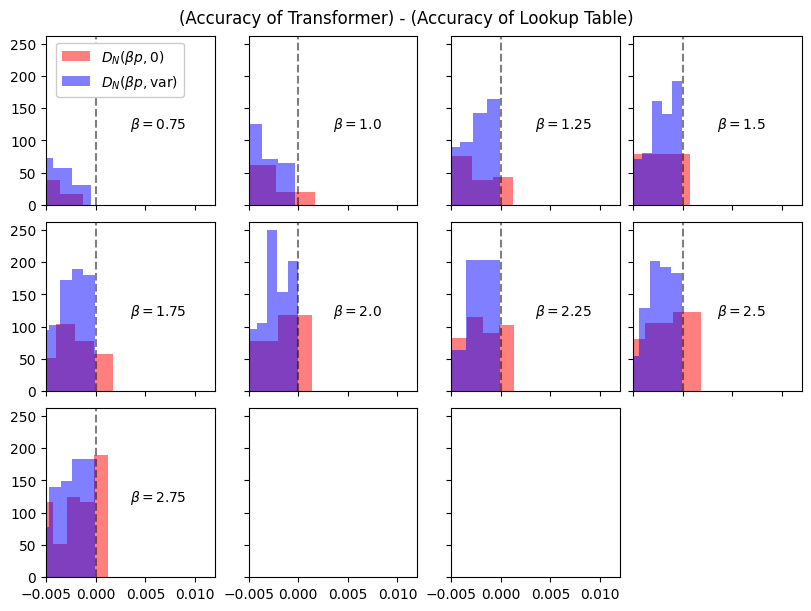

In [13]:
# make a 2D histogram of transformer vs_lookup versus betas
betavals = sorted(df_var['beta'].unique())
all_betas = []
lookup_vals_var = []
lookup_vals_novar = []
for beta in betavals:
    vs_lookupvals_var = df_var[df_var['beta'] == beta]['vs_lookup'].values
    lookup_vals_var.append(vs_lookupvals_var)
    vs_lookupvals_novar = df_novar[df_novar['beta'] == beta]['vs_lookup'].values
    lookup_vals_novar.append(vs_lookupvals_novar)

fig, axes = plt.subplots(3, 4, figsize=(8, 6), constrained_layout=True, sharex=True, sharey=True)
ax = axes.flatten()
for i in range(len(betavals)):
    beta = betavals[i]
    vals_var = lookup_vals_var[i]
    vals_novar = lookup_vals_novar[i]
    ax[i].hist(vals_novar, alpha=0.5, color='r', label=r"$D_N(\beta p, 0)$", density=True)
    _, bins, _ = ax[i].hist(vals_var, bins=20, alpha=0.5, color='b', label=r"$D_N(\beta p, \text{var})$", density=True)
    # put text with beta value in the axis
    ax[i].text(0.5, 0.45, r"$\beta=$"+f"{beta}", transform=ax[i].transAxes)
    # break
    # ax[i].set_title(f"beta={beta}")
    ax[i].axvline(0, ls='--', c='k', alpha=0.5)

ax[-1].set_visible(False)
fig.suptitle("(Accuracy of Transformer) - (Accuracy of Lookup Table)")
ax[0].legend(bbox_to_anchor=(0.02, 1), loc="upper left", framealpha=1)
ax[0].set_xlim([-0.005, 0.012])
# fig.savefig(f"../../figures/agg_toric_code_vs_lookup.pdf", bbox_inches='tight')


In [7]:
df_var.head()

,epoch,train_loss,train_acc,val_loss,val_acc,vs_lookup,vs_minweight,lr,d_model,dropout,num_encoder_layers,num_decoder_layers,nhead,dim_feedforward,batch_size,beta,var
0,1260,0.023371,0.974609,0.076210,0.957333,0.003944,0.004882,0.0020,16,0.10,3,1,4,4,64,1.0,0.03
1,3390,0.037264,0.965225,0.039548,0.963319,0.000126,0.010868,0.0005,16,0.10,2,1,2,4,2048,1.0,0.03
2,3730,0.059998,0.953125,0.078312,0.941432,0.002530,-0.011020,0.0020,20,0.15,3,1,2,8,16,1.0,0.03
3,720,0.030044,0.970215,0.059722,0.957418,0.000806,0.004967,0.0005,24,0.10,3,1,2,4,128,1.0,0.03
4,950,0.038823,0.963298,0.038782,0.963298,-0.000393,0.010847,0.0008,24,0.10,3,1,2,8,1994,1.0,0.03


#### Support of $p_E^{train}$ on important examples

In [261]:
from itertools import product
from mldec.codes import toric_code
from mldec.utils import bit_tools
ptrue = 0.05
var = 0.03
n = 9
dataset_config = {"p": ptrue, "var": var, "beta": 1.0}
error_probs = toric_code_data.make_variance_noise_model(n, dataset_config, return_probs=True)
noise_model = toric_code_data.make_variance_noise_model(n, dataset_config, return_probs=False)
X, Y, good_weights_true = toric_code_data.uniform_over_good_examples(n, dataset_config)
_, _, val_weights_true = toric_code_data.create_dataset_training(n, dataset_config)

C:\Users\peter\Desktop\projects\mldec\src\mldec\datasets\toric_code_data.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X, Y, probs = torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32), torch.tensor(probs, dtype=torch.float32)


In [262]:
# generate the distribution of errors and sort it by weight
all_errors = product([0,1], repeat=2*n)
all_errors = np.array(list(all_errors))
Xerrs = all_errors[:, :n]
Zerrs = all_errors[:, n:]
any_err = np.logical_or(Xerrs, Zerrs)

wts = any_err.sum(axis=1)
wt_idxsort = np.argsort(wts)
all_errs_wt_sorted = all_errors[wt_idxsort]
all_probs_wt_sorted = np.array([noise_model(x, n) for x in all_errs_wt_sorted])



In [263]:
# get the set of (syndrome, correction) pairs sorted by error weight
err_lookup = toric_code.build_lst_lookup(3, cache=True)
error_idx = bit_tools.bits_to_ints(all_errs_wt_sorted)
sigma_logical = err_lookup[error_idx]


In [264]:
# Build true mld
mld = baselines.LookupTable()
mld.train_on_histogram(X, Y, good_weights_true)
mwpm = baselines.MinimumWeightPerfectMatching()
mwpm.make_decoder(None, None, error_probs=error_probs)

# get the logical correction predictions for all of these
sigmas = sigma_logical[:, :8]
true_logicals = sigma_logical[:, 8:]
mld_logicals = mld.predict(sigmas).numpy()
mwpm_logicals = mwpm.predict(sigmas).numpy()


In [265]:

# # get good, bad, important idx
# idx_good = []
# idx_bad = []
# idx_important = []
# for i in range(len(true_logicals)):
#     if np.array_equal(mld_logicals[i], true_logicals[i]):
#         if np.array_equal(mwpm_logicals[i], true_logicals[i]):
#             idx_good.append(i)
#         else:
#             idx_important.append(i)
#     else:
#         idx_bad.append(i)


mask_bad = (np.logical_xor(mld_logicals, true_logicals).sum(axis=1) > 0) 
idx_bad = np.where(mask_bad > 0)[0]
mwpm_wrong = (np.logical_xor(mwpm_logicals, true_logicals).sum(axis=1) > 0)
mwpm_right = np.logical_not(mwpm_wrong)
mld_right = np.logical_not(mask_bad).astype(bool)

mask_important = (np.logical_and(mld_right, mwpm_wrong) > 0)
mask_unimportant = (np.logical_and(mld_right, mwpm_right) > 0)
# idx_important = np.where(np.logical_and(mld_right, mwpm_wrong) > 0)[0]
# idx_unimportant = np.where(np.logical_and(mld_right, mwpm_right) > 0)[0]


In [ ]:
# # fucky reaording scheme
# from math import comb

# def sort_arr_by_masks(arr, mask_unimportant, mask_important, mask_bad):
#     i = 0
#     for w in range(n + 1):
#         # slice for this weight class
#         j = i + comb(n, w) * 3 ** w
#         # print(i, j)
#         # move all the unimportant bits up front
#         slc = slice(i, j)
#         idx = np.argsort(mask_unimportant[slc])[::-1]
#         # print(idx)
#         mask_unimportant[slc] = mask_unimportant[slc][idx]
#         mask_bad[slc] = mask_bad[slc][idx]
#         mask_important[slc] = mask_important[slc][idx]
#         arr[slc] = arr[slc][idx]
#         # print(arr[i:j])
#         # print(arr[i:j][idx])

#         # move all the bad bits to the back
#         slc2 = slice(i + sum(mask_unimportant[slc]), j)
#         idx2 = np.argsort(mask_bad[slc2])
#         mask_important[slc2] = mask_important[slc2][idx2]
#         mask_bad[slc2] = mask_bad[slc2][idx2]
#         arr[slc2] = arr[slc2][idx2]

#         i += comb(n, w) * 3 ** w

#     return arr, mask_unimportant, mask_important, mask_bad

# test_len = -1

# serrs, sunimp, simp, sbad = sort_arr_by_masks(all_errs_wt_sorted[:test_len], mask_unimportant[:test_len], mask_important[:test_len], mask_bad[:test_len])
# sarr, sunimp, simp, sbad = sort_arr_by_masks(all_probs_wt_sorted[:test_len], mask_unimportant[:test_len], mask_important[:test_len], mask_bad[:test_len])

In [306]:
# now get the error probabilities for different models
high_beta_var_config = {"p": ptrue, "var": var, "beta": 3}
high_beta_novar_config = {"p": ptrue, "var": 0, "beta": 1.75}
high_beta_var_model = toric_code_data.make_variance_noise_model(n, high_beta_var_config, return_probs=False)
high_beta_novar_model = toric_code_data.make_variance_noise_model(n, high_beta_novar_config, return_probs=False)

# we automatically order these probabilities accorded to sorting in serrs
probs_high_beta_var = np.array([high_beta_var_model(x, n) for x in all_errs_wt_sorted])
probs_high_beta_novar = np.array([high_beta_novar_model(x, n) for x in all_errs_wt_sorted])

In [307]:
wts_sorted = wts[wt_idxsort]
# for each weight, we will pool the errors of the error model of the same weight together, segregated by importance
weights = {"bad": np.zeros((n+1, 3)), # second axis is [beta=1, var, novar]
            "important": np.zeros((n+1, 3)), 
            "unimportant": np.zeros((n+1, 3))}

for i in range(len(wts_sorted)):
    if mask_bad[i]:
        key = "bad"
    elif mask_important[i]:
        key = "important"
    elif mask_unimportant[i]:
        key = "unimportant"
    
    wt = wts_sorted[i]
    weights[key][wt][0] += all_probs_wt_sorted[i] # beta=1
    weights[key][wt][1] += probs_high_beta_var[i]
    weights[key][wt][2] += probs_high_beta_novar[i]

C:\Users\peter\AppData\Local\Temp\ipykernel_21732\943656549.py:15: RuntimeWarning: invalid value encountered in scalar divide
  print("SNR, var=", weights["important"][x][1] / weights["bad"][x][1])
C:\Users\peter\AppData\Local\Temp\ipykernel_21732\943656549.py:16: RuntimeWarning: invalid value encountered in scalar divide
  print("SNR, novar=", weights["important"][x][2] / weights["bad"][x][2])


SNR, var= nan
SNR, novar= nan

SNR, var= nan
SNR, novar= nan

SNR, var= 0.5859175361930723
SNR, novar= 0.4333333333333341

SNR, var= 0.18622276573759175
SNR, novar= 0.1354679802955674

SNR, var= 0.13598415069856215
SNR, novar= 0.1432291666666632

SNR, var= 0.12056964032262094
SNR, novar= 0.14253935660511508

SNR, var= 0.14705550105246606
SNR, novar= 0.15144518556511258

SNR, var= 0.22789559908111479
SNR, novar= 0.16639129836174818

SNR, var= 0.16362707760680728
SNR, novar= 0.1584533038022948

SNR, var= 0.120893223819316
SNR, novar= 0.12089322381930186




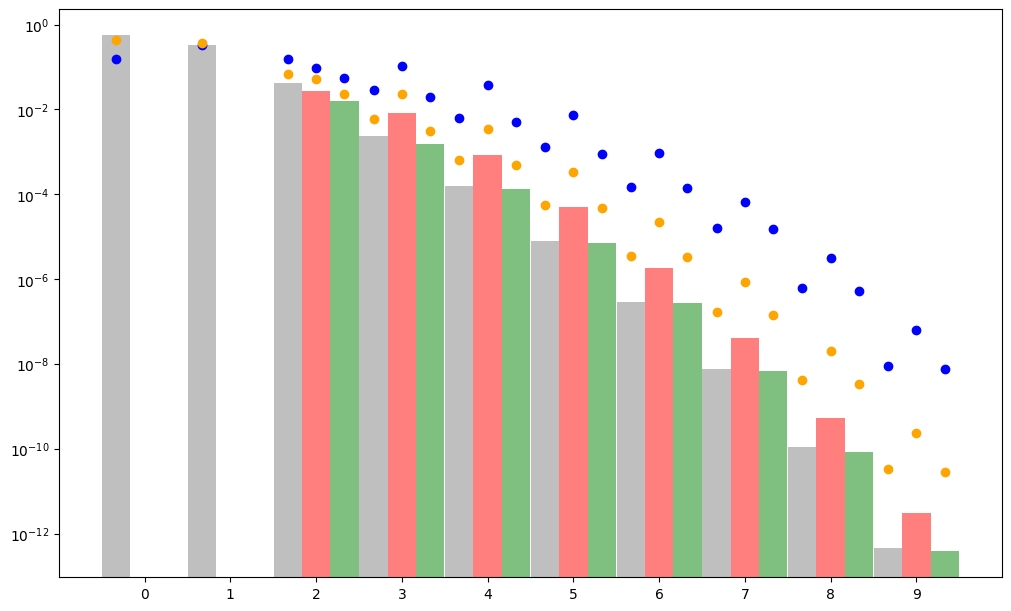

In [308]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6), constrained_layout=True)

delta  = 0.33
width = delta/2
for x in range(n+1):
    ax.bar(x - delta, weights["unimportant"][x][0], width=delta, color='gray', alpha=0.5, label="unimportant" if x == 0 else None)
    ax.bar(x, weights["bad"][x][0], width=delta, color='r', alpha=0.5, label="bad" if x == 0 else None)
    ax.bar(x + delta, weights["important"][x][0], width=delta, color='g', alpha=0.5, label="important" if x == 0 else None)

    yvals_var = [weights["unimportant"][x][1], weights["bad"][x][1], weights["important"][x][1]]
    yvals_novar = [weights["unimportant"][x][2], weights["bad"][x][2], weights["important"][x][2]]
    ax.scatter([x-delta, x, x + delta], yvals_var, c='b')
    ax.scatter([x-delta, x, x + delta], yvals_novar, c='orange')
    # ratio of important to bad
    print("SNR, var=", weights["important"][x][1] / weights["bad"][x][1])
    print("SNR, novar=", weights["important"][x][2] / weights["bad"][x][2])
    print()
ax.set_xticks(range(n+1))
ax.set_xticklabels([str(x) for x in range(n+1)])
ax.semilogy()
print()

In [ ]:



# mld = baselines.LookupTable()
# mld.train_on_histogram(X, Y, good_weights)
# mld_acc = evaluation.weighted_accuracy(mld, X, Y, val_weights) 
# print(f"MLD table accuracy: {mld_acc}")

# mld_for_novar = []
# mld_for_var = []
# betavals = sorted(df_novar['beta'].unique())
# betavals = [1.75]
# for beta in betavals:
#     novar_dataset_config = {"p": ptrue, "var": 0, "beta": beta}
#     var_dataset_config = {"p": ptrue, "var": var, "beta": beta}
#     X, Y, good_novar = toric_code_data.uniform_over_good_examples(n, novar_dataset_config)
#     X, Y, good_var = toric_code_data.uniform_over_good_examples(n, var_dataset_config)
#     # train an MLD on the no-variance noise model, and then
#     # evaluate on the "true" noise profile
#     mld_novar = baselines.LookupTable()
#     mld_novar.train_on_histogram(X, Y, good_novar)
#     acc_novar = evaluation.weighted_accuracy(mld_novar, X, Y, val_weights)
#     mld_for_novar.append(acc_novar)

#     mld_var = baselines.LookupTable()
#     mld_var.train_on_histogram(X, Y, good_var)
#     acc_var = evaluation.weighted_accuracy(mld_var, X, Y, val_weights)
#     mld_for_var.append(acc_var)
# print(mld_for_novar)
# print(mld_for_var)

In [25]:
print(min_minweight_err)
print(1 - minimum_weight_val_acc)

0.0475485
0.047548532485961914
